In [1]:
import seaborn as sns

df = sns.load_dataset('iris')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [2]:
df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [3]:
import pandas as pd

df['species'] = df['species'].map({
    'setosa': 0,
    'versicolor': 1,
    'virginica' : 2
})
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
8,4.4,2.9,1.4,0.2,0
66,5.6,3.0,4.5,1.5,1
14,5.8,4.0,1.2,0.2,0
9,4.9,3.1,1.5,0.1,0
29,4.7,3.2,1.6,0.2,0


In [4]:
X = df.drop('species', axis=1)
y = df['species']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
y_train.value_counts()

species
0    45
2    45
1    45
Name: count, dtype: int64

In [5]:
y_train.unique()

array([0, 2, 1], dtype=int64)

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score

print(f"{accuracy_score(y_test, y_pred) = }")

accuracy_score(y_test, y_pred) = 0.9333333333333333


[Text(0.375, 0.875, 'petal_width <= 0.8\ngini = 0.667\nsamples = 135\nvalue = [45, 45, 45]\nclass = setosa'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 45\nvalue = [45, 0, 0]\nclass = setosa'),
 Text(0.3125, 0.75, 'True  '),
 Text(0.5, 0.625, 'petal_width <= 1.65\ngini = 0.5\nsamples = 90\nvalue = [0, 45, 45]\nclass = versicolor'),
 Text(0.4375, 0.75, '  False'),
 Text(0.25, 0.375, 'petal_length <= 4.95\ngini = 0.12\nsamples = 47\nvalue = [0.0, 44.0, 3.0]\nclass = versicolor'),
 Text(0.125, 0.125, 'gini = 0.0\nsamples = 43\nvalue = [0, 43, 0]\nclass = versicolor'),
 Text(0.375, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]\nclass = virginica'),
 Text(0.75, 0.375, 'petal_length <= 4.85\ngini = 0.045\nsamples = 43\nvalue = [0, 1, 42]\nclass = virginica'),
 Text(0.625, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [0, 1, 3]\nclass = virginica'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39]\nclass = virginica')]

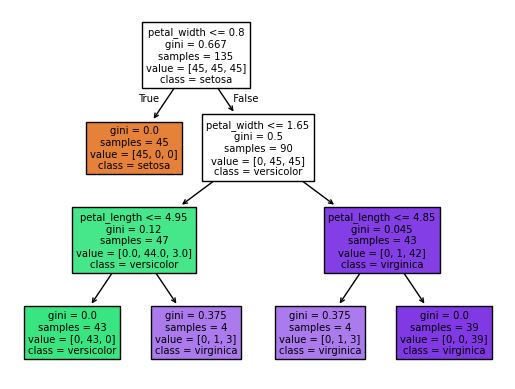

In [17]:
from sklearn import tree
tree.plot_tree(
    dt_clf, 
    filled=True,
    feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    class_names=['setosa', 'versicolor', 'virginica']
)

In [9]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [10]:
! pip install mlxtend

c:\Users\rajba\.conda\envs\tech-axis\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

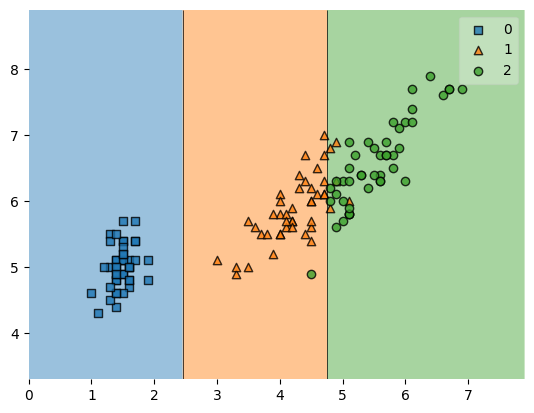

In [11]:
from mlxtend.plotting import plot_decision_regions

dt_clf = DecisionTreeClassifier(max_depth=2)
dt_clf.fit(X_train[['petal_length', 'sepal_length']], y_train)
y_pred = dt_clf.predict(X_test[['petal_length', 'sepal_length']])

plot_decision_regions(
    X_train[['petal_length', 'sepal_length']].to_numpy(), 
    y_train.to_numpy(), 
    clf=dt_clf
)

In [12]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class CustomDecisionTree:
    def __init__(self, criterion="gini", max_depth=10, min_samples_split=2):
        self.criterion = criterion.lower()
        assert self.criterion in ["gini", "entropy"], "criterion must be 'gini' or 'entropy'"
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X, np.ndarray):
            raise ValueError("X must be a pandas DataFrame or a 2D numpy array")
        
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        elif not isinstance(y, np.ndarray):
            raise ValueError("y must be a pandas Series or a 1D numpy array")
        
        self.n_classes = len(set(y))
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feat, best_thresh = self._best_split(X, y, num_features)

        if best_feat is None:
            return Node(value=self._most_common_label(y))

        left_indices = X[:, best_feat] < best_thresh
        right_indices = ~left_indices
        left = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, feature_column, threshold):
        # Parent impurity
        impurity_func = self._entropy if self.criterion == "entropy" else self._gini
        parent_impurity = impurity_func(y)

        left_mask = feature_column < threshold
        right_mask = ~left_mask

        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(y[left_mask]), len(y[right_mask])
        gain = parent_impurity - (
            (n_left / n) * impurity_func(y[left_mask]) +
            (n_right / n) * impurity_func(y[right_mask])
        )
        return gain

    def _gini(self, y):
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in proportions if p > 0])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X, np.ndarray):
            raise ValueError("X must be a pandas DataFrame or a 2D numpy array")
        
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


In [13]:
dt_clf = CustomDecisionTree(max_depth=4)
dt_clf.fit(X_train[['petal_length', 'sepal_length']], y_train)
y_pred = dt_clf.predict(X_test[['petal_length', 'sepal_length']])

In [14]:
from sklearn.metrics import accuracy_score

print(f"{accuracy_score(y_test, y_pred) = }")

accuracy_score(y_test, y_pred) = 0.9333333333333333


## Gini Impurity
- It tells how much mixed up the classes are in a group of data points.
- Gini = 1 - sum of square of probabilities of different classes
- Gini = 0 -> Pure group consisting data points of single class
- Gini > 0 -> Impure group consisting data points of more than 1 class.
- Lowest Gini = 0
- Highest GIni = 1 - (1/N), where N is the number of class   

## Entropy Impurity
- It measures the uncertainty/ randomness in the group of data points.
- Entropy =  negative sum of product of probability and log base 2 of probability
- Entropy = 0 -> Pure
- Entropy > 0 -> Impure

### Example
basket A - 6 red ballons 
basket B - 2 red balloons and 2 blue balloons
basket C - 1 red, 1 blue, 1 green
basket B - 90 red, 2 blue

---------------------------
- Basket A: 
    - P_red = 6/6 = 1
    - Gini = 1 - (1 ** 2) = 1 - 1 = 0
    - Entropy = -(1 * log2(1)) = 0
- Basket B:
  - P_red = 2/4 = 0.5
  - P_blue = 2/4 = 0.5
  - Gini = 1 - (0.5 ** 2 + 0.5 ** 2) = 1 - (0.25 + 0.25) = 0.5
  - ENtorpy = -(0.5 * log2(0.5) + 0.5 * log2(0.5)) = 1
- Basket C:
  - P_red = 1/3 = 0.3333
  - P_blue = 1/3 = 0.3333
  - P_green = 1/3 = 0.3333
  - Gini = 1 - (0.33 ** 2 + 0.33 ** 2 + 0.33 ** 2) = 1 - 0.3267 = 0.6733
  - Entropy = -(0.33 * log2(0.33) + 0.33 * log2 (0.33) + 0.33 * log2 (0.33)) = 1.5834
- Basket D:
  - P_red = 90/92 = 0.978
  - P_blue = 2/92 = 0.022
  - Gini = 1 - ( 0.978 ** 2 + 0.022 ** 2) = 0.043
  - Entropy = -(0.978 * log2(0.978) + 0.022 * log2(0.022)) = 0.1525

In [26]:
import numpy as np
-(0.978 * np.log2(0.978) + 0.022 * np.log2(0.022))

0.15252732850878192